# Curve Fitting

NLopt does not contain dedicated algorithms for curve fitting but any nonlinear optimization algorithm can be used for curve fitting. The curve_fit function is a simple convenience function to make curve fitting more straightforward. As for general local and global optimization, the API mimics SciPy to make testing different algorithms as simple as possible. Unlike SciPy, all available local optimizers can be employed to perform the fitting.

## Fitting a simple model
In this tutorial we will recreate SciPy's curve fitting [example](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

The model to be fitted has to be supplied as f(x, param_1, param_2, ... param_n) where x denotes the independent variable and the other variables the parameters we want to estimate. The three-parameter model to be fitted is given by an exponential decay plus an offset:

$$
f(x|a, b, c)=c + a\cdot e^{-b\cdot x}
$$

Least squares fitting means that the sum of the squared differences between the predictions made by the model and the observed data is minimized. In this case:
$$
\underset{a,b,c}{\mathrm{argmin}} \sum_i \bigl(f(x_i|a, b, c)-y_i\bigl)^2
$$
First, we set ground truth parameters, generate a model prediction and add some gaussian noise.

In [1]:
import numpy as np
import simplenlopt
import matplotlib.pyplot as plt

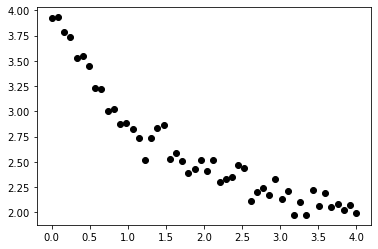

In [2]:
def model(x, a, b, c):

    return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4,50)
a_true = 2.
b_true = 0.8
c_true = 2.
y = model(xdata, a_true, b_true, c_true)
y_data = y + 0.1 * np.random.normal(size=xdata.size)

plt.scatter(xdata, y_data, c = 'k')
plt.show()

Now we can fit the model using the curve_fit function. Its calling signature is the same as SciPy's: it requires at least a model, xdata and ydata. Its return values differ slightly from SciPy: the first return value is the best parameter vector but the second return value contains the optimized least squares objective which is typically called $\chi^2$. SciPy's approximation of the covariance matrix is currently not implemented in simplenlopt.

Estimated model parameters:  [2.02912871 0.75783832 1.96606768]
Chi squared:  0.46471142986631825


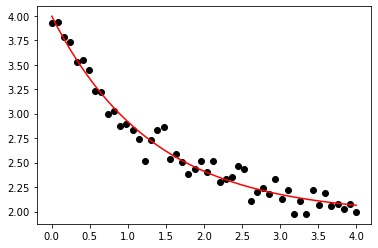

In [9]:
params, chi_squared = simplenlopt.curve_fit(model, xdata, y_data)
print("Estimated model parameters: ", params)
print("Chi squared: ", chi_squared)

plt.scatter(xdata, y_data, c = 'k')
plt.plot(xdata, model(xdata, *params), c='r')
plt.show()

Unlike scipy, simplenlopt will use a gradient-free algorithm (BOBYQA) if no gradient information is supplied. Gradient information must be supplied as an N x m numpy array for N data points and m parameters. Each column of the gradient matrix must contain the partial derivative with respect to one parameter for all data points. To make this less confusing, the code below shows how to supply the gradient for this example:

In [4]:
def jac_model(x, a, b, c):

    da = np.exp(-b * x)
    db = -x * a * np.exp(-b * x)
    dc = np.full_like(x, 1.)
    
    return np.array([da.ravel(), db.ravel(), dc.ravel()])

params, chi_squared = simplenlopt.curve_fit(model, xdata, y_data, jac = jac_model)
print("Estimated model parameters: ", params)

Estimated model parameters:  [2.02914344 0.75787158 1.96608409]


## Troubleshooting difficult fits
Next, let's try a more complicated example to show how the choice of optimizers and starting guesses affects the fitting results. We will add a gaussian peak to the model to make it more complex:

$$
f(x|a, b, c, d, e, f)=c + a\cdot e^{-b\cdot x} +d\cdot \exp\left(\frac{-(e-x)^2}{f^2}\right)
$$
Again, let's first generate some fake data.

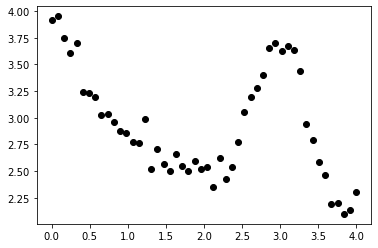

In [5]:
def complex_model(x, a, b, c, d, e, f):

    return a * np.exp(-b * x) + c + d * np.exp(-(e-x)**2/f**2)

d_true = 1.5
e_true = 3.
f_true = 0.5

true_params = np.array([a_true, b_true, c_true, d_true, e_true, f_true])
y_complex = complex_model(xdata, *true_params)
y_noisy = y_complex + 0.1 * np.random.normal(size=xdata.size)
plt.scatter(xdata, y_noisy, c = 'k')

By default, the initial guess for all model parameters is 1. This guess is far away from the true parameters in this example. A starting point far away from the true parameters also makes it hard for the optimizer to find the true parameters. To illustrate this, let's plot the model prediction for the initial guesses and the parameters found by the default optimizer, BOBYQA.

<ipython-input-5-57e43c5c3f19>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a * np.exp(-b * x) + c + d * np.exp(-(e-x)**2/f**2)


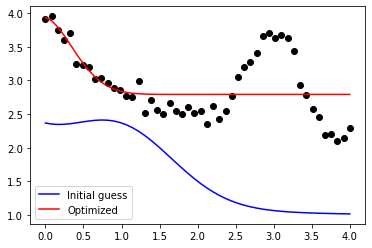

In [6]:
initial_guesses = np.array([1., 1., 1., 1., 1., 1.])
optimized_params, chi_squared = simplenlopt.curve_fit(complex_model, xdata, y_noisy)
plt.scatter(xdata, y_noisy, c = 'k')
plt.plot(xdata, complex_model(xdata, *initial_guesses), c='b', label='Initial guess')
plt.plot(xdata, complex_model(xdata, *optimized_params), c='r', label='Optimized')
plt.legend()
plt.show()

Ugh, obviously a bad fit. Let's try different starting guesses: we guess the peak position to be at 2.5.

<ipython-input-5-57e43c5c3f19>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a * np.exp(-b * x) + c + d * np.exp(-(e-x)**2/f**2)


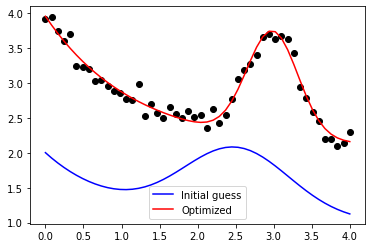

In [7]:
initial_guesses=np.array([1., 1., 1., 1., 2.5, 1.])
optimized_params, chi_squared = simplenlopt.curve_fit(complex_model, xdata, y_noisy, p0 = initial_guesses)
plt.scatter(xdata, y_noisy, c = 'k')
plt.plot(xdata, complex_model(xdata, *initial_guesses), c='b', label='Initial guess')
plt.plot(xdata, complex_model(xdata, *optimized_params), c='r', label='Optimized')
plt.legend()
plt.show()

This looks much better! Keep in mind that it is always better to supply an initial estimate for the model parameters. If your parameters are far away from 1, fitting will not work without it. 

That being said, it is also always a good idea to test different optimizers. We will try to fit the model using the default guesses of 1 for all parameters using the Method of Moving Asymptotes and compare it with the BOBYQA result.

<ipython-input-5-57e43c5c3f19>:3: RuntimeWarning: divide by zero encountered in true_divide
  return a * np.exp(-b * x) + c + d * np.exp(-(e-x)**2/f**2)
C:\ProgramData\Anaconda3\lib\site-packages\simplenlopt\_Core.py:178: RuntimeWarning: Using gradient-based optimization, but no gradient information is available. Gradient will be approximated by central difference. Consider using a derivative-free optimizer or supplying gradient information.
  warn('Using gradient-based optimization'


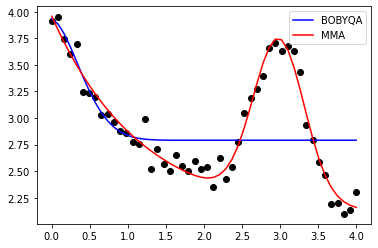

In [8]:
params_bobyqa, bobyqa_chi_squared = simplenlopt.curve_fit(complex_model, xdata, y_noisy, method = 'BOBYQA')
params_mma, mma_chi_squared = simplenlopt.curve_fit(complex_model, xdata, y_noisy, method = 'MMA')
plt.scatter(xdata, y_noisy, c = 'k')
plt.plot(xdata, complex_model(xdata, *params_bobyqa), c='b', label='BOBYQA')
plt.plot(xdata, complex_model(xdata, *params_mma), c='r', label='MMA')
plt.legend()
plt.show()

Clearly, MMA outperforms BOBYQA in this case. As always with nonlinear optimization though, this does not have to be true for all models.

## Robust fits for outlier handling